***Week 4 Miniproject - Disaster Tweets***

**Step1: Brief description of problem and data**

The objective of this problem is to create a RNN that is able to reconize twitter entries reporting on emergencies. Twitter is a vital platform for real-time communication during disasters. With widespread smartphone use, people can instantly report observed emergencies. Organizations like disaster relief agencies and news outlets seek to monitor Twitter for such announcements. However, distinguishing whether a tweet is genuinely about a disaster can be challenging.

**Data**
The dataset includes tweets labeled as either related to a disaster or not. The objective is to develop a model that can accurately classify tweets based on this criteria, aiding in the timely identification of disaster-related information. The dataset has 10,000 tweets that where classified by hand.

To address this problem, we will use the NLP starter guide provided by Keras as our base example. The Keras starter guide utilizes DistilBERT as the pre-trained model. We will fine-tune this model to create an original submission. Additionally, we will train other architectures to compare the results. Starter notebook from the Keras team: https://www.kaggle.com/code/alexia/kerasnlp-starter-notebook-disaster-tweets



In [1]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import keras
import keras_nlp
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV


print("TensorFlow version:", tf.__version__)
print("Keras version:", tf.__version__)
print("KerasNLP version:", keras_nlp.__version__)

2024-06-23 22:38:03.844766: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-23 22:38:03.844869: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-23 22:38:03.975635: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow version: 2.15.0
Keras version: 2.15.0
KerasNLP version: 0.12.1


**Step2: Exploratory Data Analysis (EDA)**

In this section, we will load the disaster tweets dataset and perform an exploratory data analysis. We will display the data and identify features that are not essential for model training. Additionally, we have implemented a function to load only a fraction of the data for debugging purposes.

In [3]:
# Function to load data with an optional fraction for debugging
def load_data(fraction=None):
    df_train = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
    df_test = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")
    
    if fraction:
        df_train = df_train.sample(frac=fraction, random_state=42)
        df_test = df_test.sample(frac=fraction, random_state=42)
    
    print('Training Set Shape = {}'.format(df_train.shape))
    print('Training Set Memory Usage = {:.2f} MB'.format(df_train.memory_usage().sum() / 1024**2))
    print('Test Set Shape = {}'.format(df_test.shape))
    print('Test Set Memory Usage = {:.2f} MB'.format(df_test.memory_usage().sum() / 1024**2))
    
    return df_train, df_test

df_train, df_test = load_data(fraction=1.00)  # Adjust the fraction as needed

df_train.head()

Training Set Shape = (7613, 5)
Training Set Memory Usage = 0.35 MB
Test Set Shape = (3263, 4)
Test Set Memory Usage = 0.12 MB


,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


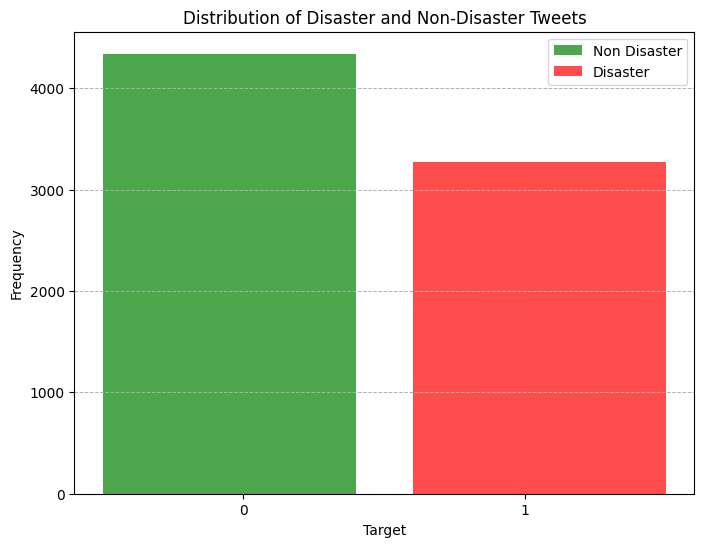

In [4]:
# Plotting the histogram 
plt.figure(figsize=(8, 6))
plt.hist(df_train[df_train['target'] == 0]['target'], bins=[-0.5, 0.4], alpha=0.7, color='green', label='Non Disaster')
plt.hist(df_train[df_train['target'] == 1]['target'], bins=[0.6, 1.5], alpha=0.7, color='red', label='Disaster')

plt.xlabel('Target')
plt.ylabel('Frequency')
plt.title('Distribution of Disaster and Non-Disaster Tweets')

# Set x-axis labels to only show 0 and 1, centered
plt.xticks([0, 1], ['0', '1'])

plt.grid(axis='y', linestyle='--', linewidth=0.7)
plt.legend()
plt.show()

In [5]:
df_test.head()

,id,keyword,location,text
2406,8051,refugees,NaN,Refugees as citizens - The Hindu http://t.co/G...
134,425,apocalypse,Currently Somewhere On Earth,@5SOStag honestly he could say an apocalypse i...
411,1330,blown%20up,Scout Team,If you bored as shit don't nobody fuck wit you...
203,663,attack,NaN,@RealTwanBrown Yesterday I Had A Heat Attack ?...
889,2930,danger,Leeds,The Devil Wears Prada is still one of my favou...


In the training DataFrame, only the 'text' and 'target' columns will be relevant for model training. All other irrelevant columns will be dropped. In the test DataFrame, only the 'text' column will be used. After cleaning the dataset, we will print some data statistics to provide a comprehensive overview.

In [6]:
df_train["length"] = df_train["text"].apply(lambda x : len(x))
df_test["length"] = df_test["text"].apply(lambda x : len(x))

print("Train Length Stat")
print(df_train["length"].describe())
print()

print("Test Length Stat")
print(df_test["length"].describe())

Train Length Stat
count    7613.000000
mean      101.037436
std        33.781325
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: length, dtype: float64

Test Length Stat
count    3263.000000
mean      102.108183
std        33.972158
min         5.000000
25%        78.000000
50%       109.000000
75%       134.000000
max       151.000000
Name: length, dtype: float64


**STEP 3: Model Arquitecture** 

In this step, we will preprocess the data, batch it, and split it into training and validation sets. We will also specify the hyperparameters of the models.

Regardind the arquitectures, the Keras starter guide utilizes DistilBERT as the pre-trained model. DistilBERT is a smaller, faster, and lighter version of BERT, making it a practical choice for our needs due to its ease of availability and efficient upload time. This model maintains 97% of BERT's performance while being 60% faster and 40% lighter, which is advantageous for both training and deployment.

In addition to DistilBERT, we will train other architectures to compare the results. This other arquitectures are:

FNet: FNet is chosen because it introduces a Fourier Transform-based architecture that is less computationally intensive than traditional transformers. This allows it to handle longer sequences more efficiently, potentially offering performance benefits in terms of both speed and memory usage.

ALBERT: ALBERT (A Lite BERT) is another variant of BERT that reduces the model size through parameter-sharing and factorized embeddings. It is designed to be lighter and faster while still delivering robust performance, making it a good candidate for comparison against DistilBERT and FNet.

The main criteria for this selection was the model size, the performance and the availability.We also tried to use Mistral, GPT2 and Electra, but were quite heavy to download and the resources available at Kaggle were not adequate for this purpose. 

After fine-tuning these models and performing hyperparameter optimization, we will evaluate their performance to determine the most effective model for our task. Key metrics for this evaluation will include accuracy and F1 score.


In [7]:
BATCH_SIZE = 32
NUM_TRAINING_EXAMPLES = df_train.shape[0]
TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.2
STEPS_PER_EPOCH = int(NUM_TRAINING_EXAMPLES)*TRAIN_SPLIT // BATCH_SIZE

EPOCHS = 2
AUTO = tf.data.experimental.AUTOTUNE

In [8]:
# Split the data
X = df_train["text"]
Y = df_train["target"]
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=VAL_SPLIT, random_state=42)
X_test = df_test["text"]

To streamline the process, we will create functions for each model.

In [9]:

def build_distilbert_model(learning_rate=1e-5):
    preset = "distil_bert_base_en_uncased"
    preprocessor = keras_nlp.models.DistilBertPreprocessor.from_preset(preset, sequence_length=160)
    classifier = keras_nlp.models.DistilBertClassifier.from_preset(preset, preprocessor=preprocessor, num_classes=2)
    classifier.compile(
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        optimizer=keras.optimizers.Adam(learning_rate),
        metrics=["accuracy"]
    )
    return classifier

# Train and save the base DistilBERT model
base_distilbert_model = build_distilbert_model()
base_distilbert_model.fit(X_train, Y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(X_val, Y_val))
base_distilbert_model.save("base_distilbert_model.h5")


Attaching 'metadata.json' from model 'keras/distil_bert/keras/distil_bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'metadata.json' from model 'keras/distil_bert/keras/distil_bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'preprocessor.json' from model 'keras/distil_bert/keras/distil_bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'tokenizer.json' from model 'keras/distil_bert/keras/distil_bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'tokenizer.json' from model 'keras/distil_bert/keras/distil_bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'assets/tokenizer/vocabulary.txt' from model 'keras/distil_bert/keras/distil_bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'metadata.json' from model 'keras/distil_bert/keras/distil_bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'metadata.json' from model 'keras/distil_bert/keras/distil_bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'task.

Epoch 1/2


I0000 00:00:1719182363.767802      66 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1719182363.813022      66 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step - accuracy: 0.7183 - loss: 0.5824

W0000 00:00:1719182444.781325      68 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719182448.212796      67 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


191/191 ━━━━━━━━━━━━━━━━━━━━ 146s 469ms/step - accuracy: 0.7187 - loss: 0.5819 - val_accuracy: 0.8142 - val_loss: 0.4143
Epoch 2/2


W0000 00:00:1719182453.167650      68 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


191/191 ━━━━━━━━━━━━━━━━━━━━ 47s 246ms/step - accuracy: 0.8472 - loss: 0.3748 - val_accuracy: 0.8214 - val_loss: 0.4059


In [10]:

# Hyperparameter optimization for DistilBERT
learning_rates = [1e-5, 3e-5, 5e-5]
best_accuracy = 0
improved_distilbert_model = None

for lr in learning_rates:
    model = build_distilbert_model(learning_rate=lr)
    model.fit(X_train, Y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(X_val, Y_val))
    val_accuracy = model.evaluate(X_val, Y_val)[1]
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        improved_distilbert_model = model

# Save the best model
improved_distilbert_model.save("best_distilbert_model.h5")


Attaching 'metadata.json' from model 'keras/distil_bert/keras/distil_bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'metadata.json' from model 'keras/distil_bert/keras/distil_bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'preprocessor.json' from model 'keras/distil_bert/keras/distil_bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'tokenizer.json' from model 'keras/distil_bert/keras/distil_bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'tokenizer.json' from model 'keras/distil_bert/keras/distil_bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'assets/tokenizer/vocabulary.txt' from model 'keras/distil_bert/keras/distil_bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'metadata.json' from model 'keras/distil_bert/keras/distil_bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'metadata.json' from model 'keras/distil_bert/keras/distil_bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'task.

Epoch 1/2


W0000 00:00:1719182600.640781      66 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step - accuracy: 0.7207 - loss: 0.5707

W0000 00:00:1719182679.254574      67 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719182682.466163      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


191/191 ━━━━━━━━━━━━━━━━━━━━ 142s 453ms/step - accuracy: 0.7210 - loss: 0.5703 - val_accuracy: 0.8280 - val_loss: 0.4072
Epoch 2/2


W0000 00:00:1719182686.968241      67 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


191/191 ━━━━━━━━━━━━━━━━━━━━ 47s 246ms/step - accuracy: 0.8478 - loss: 0.3750 - val_accuracy: 0.8326 - val_loss: 0.4033
48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - accuracy: 0.8162 - loss: 0.4283


Attaching 'metadata.json' from model 'keras/distil_bert/keras/distil_bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'metadata.json' from model 'keras/distil_bert/keras/distil_bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'preprocessor.json' from model 'keras/distil_bert/keras/distil_bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'tokenizer.json' from model 'keras/distil_bert/keras/distil_bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'tokenizer.json' from model 'keras/distil_bert/keras/distil_bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'assets/tokenizer/vocabulary.txt' from model 'keras/distil_bert/keras/distil_bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'metadata.json' from model 'keras/distil_bert/keras/distil_bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'metadata.json' from model 'keras/distil_bert/keras/distil_bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'task.

Epoch 1/2


W0000 00:00:1719182801.602134      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step - accuracy: 0.7742 - loss: 0.5023

W0000 00:00:1719182885.563492      66 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719182888.891449      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


191/191 ━━━━━━━━━━━━━━━━━━━━ 146s 482ms/step - accuracy: 0.7743 - loss: 0.5020 - val_accuracy: 0.8234 - val_loss: 0.4042
Epoch 2/2


W0000 00:00:1719182893.386998      68 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


191/191 ━━━━━━━━━━━━━━━━━━━━ 47s 247ms/step - accuracy: 0.8680 - loss: 0.3331 - val_accuracy: 0.8339 - val_loss: 0.4065
48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - accuracy: 0.8184 - loss: 0.4436


Attaching 'metadata.json' from model 'keras/distil_bert/keras/distil_bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'metadata.json' from model 'keras/distil_bert/keras/distil_bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'preprocessor.json' from model 'keras/distil_bert/keras/distil_bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'tokenizer.json' from model 'keras/distil_bert/keras/distil_bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'tokenizer.json' from model 'keras/distil_bert/keras/distil_bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'assets/tokenizer/vocabulary.txt' from model 'keras/distil_bert/keras/distil_bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'metadata.json' from model 'keras/distil_bert/keras/distil_bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'metadata.json' from model 'keras/distil_bert/keras/distil_bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'task.

Epoch 1/2


W0000 00:00:1719183012.121794      67 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - accuracy: 0.7518 - loss: 0.5060

W0000 00:00:1719183095.930107      67 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719183099.300549      67 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


191/191 ━━━━━━━━━━━━━━━━━━━━ 148s 482ms/step - accuracy: 0.7520 - loss: 0.5057 - val_accuracy: 0.8299 - val_loss: 0.3953
Epoch 2/2


W0000 00:00:1719183103.819141      67 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


191/191 ━━━━━━━━━━━━━━━━━━━━ 47s 247ms/step - accuracy: 0.8731 - loss: 0.3179 - val_accuracy: 0.8148 - val_loss: 0.4530
48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - accuracy: 0.8074 - loss: 0.4883


In [11]:
def build_albert_model():
    preset = "albert_base_en_uncased"
    preprocessor = keras_nlp.models.AlbertPreprocessor.from_preset(preset, sequence_length=160)
    classifier = keras_nlp.models.AlbertClassifier.from_preset(preset, preprocessor=preprocessor, num_classes=2)
    classifier.compile(
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        optimizer=keras.optimizers.Adam(1e-5),
        metrics=["accuracy"]
    )
    return classifier

albert_model = build_albert_model()
albert_model.fit(X_train, Y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(X_val, Y_val))
albert_model.save("albert_model.h5")

Attaching 'metadata.json' from model 'keras/albert/keras/albert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'metadata.json' from model 'keras/albert/keras/albert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'preprocessor.json' from model 'keras/albert/keras/albert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'tokenizer.json' from model 'keras/albert/keras/albert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'tokenizer.json' from model 'keras/albert/keras/albert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'assets/tokenizer/vocabulary.spm' from model 'keras/albert/keras/albert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'metadata.json' from model 'keras/albert/keras/albert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'metadata.json' from model 'keras/albert/keras/albert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'task.json' from model 'keras/albert/keras/albert_base_en_uncased/2' to your Kaggle no

Epoch 1/2


W0000 00:00:1719183191.378947      68 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.6859 - loss: 0.5858

W0000 00:00:1719183278.428517      68 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719183282.861193      67 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


191/191 ━━━━━━━━━━━━━━━━━━━━ 127s 524ms/step - accuracy: 0.6862 - loss: 0.5855 - val_accuracy: 0.7787 - val_loss: 0.4844
Epoch 2/2


W0000 00:00:1719183291.305346      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


191/191 ━━━━━━━━━━━━━━━━━━━━ 83s 435ms/step - accuracy: 0.7923 - loss: 0.4550 - val_accuracy: 0.7892 - val_loss: 0.4630


In [12]:

# Load and fine-tune FNet model
def build_fnet_model():
    preset = "f_net_base_en"
    preprocessor = keras_nlp.models.FNetPreprocessor.from_preset(preset, sequence_length=160)
    classifier = keras_nlp.models.FNetClassifier.from_preset(preset, preprocessor=preprocessor, num_classes=2)
    classifier.compile(
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        optimizer=keras.optimizers.Adam(1e-5),
        metrics=["accuracy"]
    )
    return classifier

fnet_model = build_fnet_model()
fnet_model.fit(X_train, Y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(X_val, Y_val))
fnet_model.save("fnet_model.h5")

Attaching 'metadata.json' from model 'keras/f_net/keras/f_net_base_en/2' to your Kaggle notebook...
Attaching 'metadata.json' from model 'keras/f_net/keras/f_net_base_en/2' to your Kaggle notebook...
Attaching 'preprocessor.json' from model 'keras/f_net/keras/f_net_base_en/2' to your Kaggle notebook...
Attaching 'tokenizer.json' from model 'keras/f_net/keras/f_net_base_en/2' to your Kaggle notebook...
Attaching 'tokenizer.json' from model 'keras/f_net/keras/f_net_base_en/2' to your Kaggle notebook...
Attaching 'assets/tokenizer/vocabulary.spm' from model 'keras/f_net/keras/f_net_base_en/2' to your Kaggle notebook...
Attaching 'metadata.json' from model 'keras/f_net/keras/f_net_base_en/2' to your Kaggle notebook...
Attaching 'metadata.json' from model 'keras/f_net/keras/f_net_base_en/2' to your Kaggle notebook...
Attaching 'task.json' from model 'keras/f_net/keras/f_net_base_en/2' to your Kaggle notebook...
Attaching 'config.json' from model 'keras/f_net/keras/f_net_base_en/2' to your K

Epoch 1/2


W0000 00:00:1719183434.381970      66 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719183434.656341      66 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719183434.665813      66 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719183434.673890      66 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719183434.681836      66 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719183434.689856      66 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719183434.697902      66 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719183434.705882      66 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


  1/191 ━━━━━━━━━━━━━━━━━━━━ 2:48:02 53s/step - accuracy: 0.5312 - loss: 0.6810

W0000 00:00:1719183434.863231      66 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719183434.877458      66 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719183434.891553      66 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719183434.906071      66 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719183434.920640      66 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719183434.934876      66 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - accuracy: 0.6723 - loss: 0.6023

W0000 00:00:1719183520.524364      66 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719183520.529112      66 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719183520.532122      66 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719183520.535150      66 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719183520.538139      66 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719183520.541151      66 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719183520.544153      66 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719183520.547159      66 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


191/191 ━━━━━━━━━━━━━━━━━━━━ 148s 499ms/step - accuracy: 0.6726 - loss: 0.6019 - val_accuracy: 0.7971 - val_loss: 0.4531
Epoch 2/2


W0000 00:00:1719183529.705207      67 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719183529.706639      67 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719183529.711274      67 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719183529.715901      67 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719183529.720516      67 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719183529.725136      67 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719183529.729796      67 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719183529.734471      67 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


191/191 ━━━━━━━━━━━━━━━━━━━━ 56s 294ms/step - accuracy: 0.8188 - loss: 0.4241 - val_accuracy: 0.8070 - val_loss: 0.4371


 3/48 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step

W0000 00:00:1719183593.058972      66 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 112ms/step


W0000 00:00:1719183598.336217      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 3/48 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step

W0000 00:00:1719183601.603899      66 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 109ms/step


W0000 00:00:1719183606.730533      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 2/48 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step

W0000 00:00:1719183611.027618      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


48/48 ━━━━━━━━━━━━━━━━━━━━ 13s 201ms/step


W0000 00:00:1719183620.489269      68 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 3/48 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step

W0000 00:00:1719183623.743199      67 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719183623.744997      67 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719183623.752122      67 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719183623.759417      67 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719183623.766696      67 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719183623.773897      67 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719183623.781073      67 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719183623.788319      67 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step


W0000 00:00:1719183630.092538      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719183630.093818      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719183630.098570      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719183630.103201      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719183630.107809      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719183630.112426      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719183630.116966      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719183630.121551      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


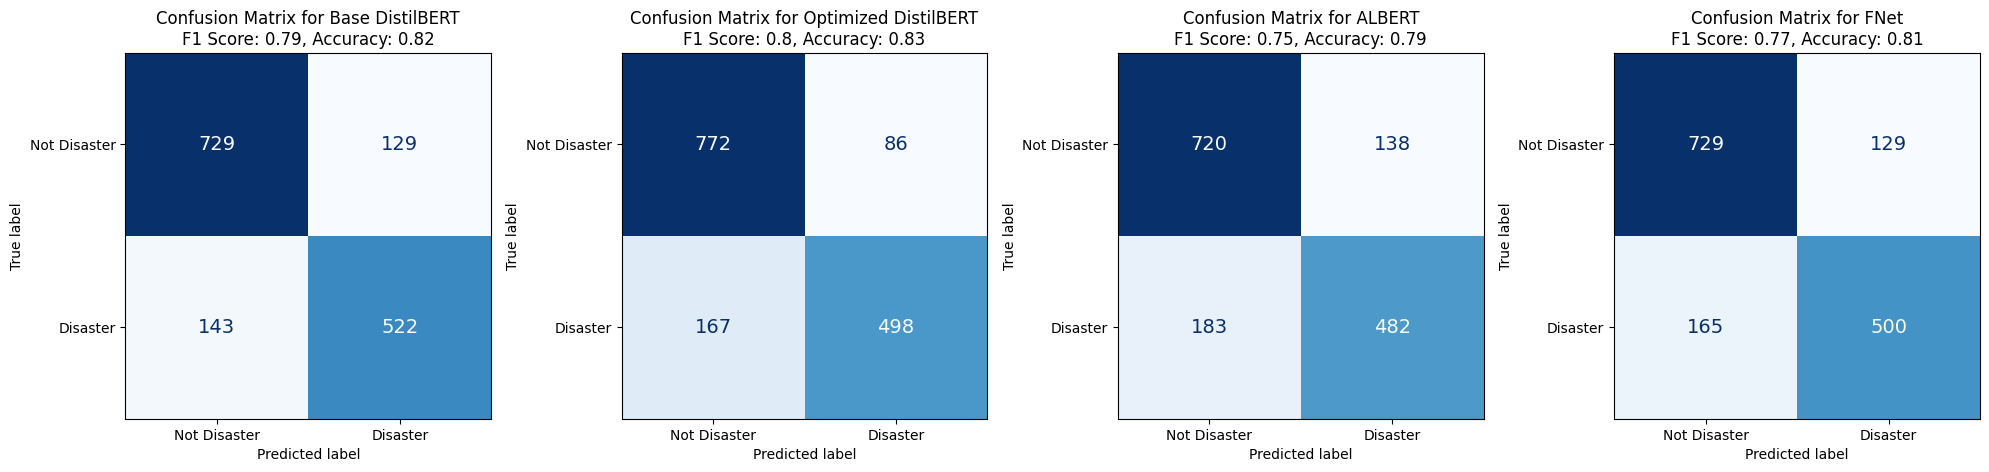

In [13]:
# Function to display the confusion matrix
def displayConfusionMatrix(y_true, y_pred, model_name, ax):
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true,
        np.argmax(y_pred, axis=1),
        display_labels=["Not Disaster", "Disaster"],
        cmap=plt.cm.Blues,
        ax=ax,
        colorbar=False  # Disable the color legend
    )
    tn, fp, fn, tp = confusion_matrix(y_true, np.argmax(y_pred, axis=1)).ravel()
    f1_score = tp / (tp + ((fn + fp) / 2))
    accuracy = (tp + tn) / (tn + fp + fn + tp)
    ax.set_title(f"Confusion Matrix for {model_name}\nF1 Score: {f1_score.round(2)}, Accuracy: {accuracy.round(2)}")
    # Make the numbers in the confusion matrix bigger
    for text in disp.ax_.texts:
        text.set_fontsize(14)

# Compare confusion matrices for all models
models = {
    "Base DistilBERT": base_distilbert_model,
    "Optimized DistilBERT": improved_distilbert_model,
    "ALBERT": albert_model,
    "FNet": fnet_model
}

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))

for ax, (model_name, model) in zip(axes, models.items()):
    Y_pred_val = model.predict(X_val)
    displayConfusionMatrix(Y_val, Y_pred_val, model_name, ax)

plt.tight_layout()
plt.show()

In [14]:
# Determine the best model based on validation accuracy
best_model_name = max(models, key=lambda name: models[name].evaluate(X_val, Y_val)[1])
best_model = models[best_model_name]

48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - accuracy: 0.8021 - loss: 0.4332
48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - accuracy: 0.8184 - loss: 0.4436
48/48 ━━━━━━━━━━━━━━━━━━━━ 7s 135ms/step - accuracy: 0.7734 - loss: 0.4768
48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - accuracy: 0.7974 - loss: 0.4551


**STEP 4: Results and analysis**

The optimized DistilBERT model slightly outperforms the base DistilBERT, ALBERT, and FNet models in terms of both F1 score and accuracy. This improvement can be attributed to the hyperparameter tuning process, which likely enhanced the model's ability to generalize from the training data. Comparing DistilBERT with its optimized version, the optimization process has significantly reduced the false positive rate (from 129 to 86), leading to a higher accuracy and F1 score. This indicates that hyperparameter tuning can substantially impact model performance if we continue performing other hyperparameter optimization.

While both DistilBERT and ALBERT are designed to be lighter versions of BERT, DistilBERT seems to perform better overall. This could be due to its architecture, which might be better suited for the specific task of tweet classification. Although FNet also offers a lighter model architecture, it does not perform as well as the optimized DistilBERT. 

Overall, the optimized DistilBERT model demonstrates a superior performance, suggesting that careful tuning and optimization of hyperparameters are crucial steps in developing effective machine learning models.

**SETP 5: Conclusions**

In conclusion, the optimized DistilBERT model achieved the highest accuracy and F1 score among the tested models, indicating its suitability for the task of disaster tweet classification. The performance differences between the models highlight the importance of model selection and hyperparameter tuning. 

Future work could involve further hyperparameter tuning, as additional fine-tuning of hyperparameters for all models could yield further performance improvements.

Implementing data augmentation techniques might help in enhancing model robustness and generalization. Exploring advanced text preprocessing methods, such as handling emojis, hashtags, and user mentions, could improve model performance. There is also one limitation of the models, because they are not able to distinguish metion Upper Cases and Lower Cases, and this may be an important missing feature in the identification of emergency tweets and sentiment analysis.

**Append 1: Submission file**

In [15]:
# Run sample submission with the best model
sample_submission = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")
sample_submission["target"] = np.argmax(best_model.predict(X_test), axis=1)
sample_submission.describe()
sample_submission.to_csv("submission.csv", index=False)

print(f"Sample submission generated using the best model: {best_model_name}")

102/102 ━━━━━━━━━━━━━━━━━━━━ 9s 82ms/step
Sample submission generated using the best model: Optimized DistilBERT


W0000 00:00:1719183664.121572      66 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
